# Astrometry Autocorrelation (MAPS)

The maps in this notebook are reproduced with **numerical integration**, the functions for this calculations are defined in **response.py**

In [1]:
import numpy as np
import healpy as hp
import itertools
import jax.numpy as jnp
from jax import vmap, grad
from response import pairwise_monopole, pairwise_dipole, vvec, trace_pair_pair_H0, trace_pair_pair_H1
from jax import config

# plot settings
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

font = {'size': 12, 'family':'Serif'}
#font = {'size': 18, 'family':'Latin Modern Roman'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Monopole visualisation

Map for $H_{ij}^{(0)}$ defined in the equation (2.9) from 2412.14010. 

We consider:
* $\bf p$ the direction of the GW propagation,
* $\bf q$ the positions of the stars as the position of each of the pixels of the map. You will see in the code an array defined as **stars_vec** that contains all these vectors and,
* $\bf{n} =(0 ,0)$.


In [2]:
# The integration is over 'p'. 
# pvec_array contains the' p' directions spread in a pixelated sphere.

nside = 32
npix = hp.nside2npix(nside)
pix = np.arange(npix)
#print(n1.shape,pix.shape)

pvec_array = np.array(hp.pix2vec(nside,pix)).T
#print(np.shape(pvec_array))

# The next lines test the integration with the array defined above:
get_vec = lambda theta,phi: jnp.array([jnp.sin(theta)*jnp.cos(phi),jnp.sin(theta)*jnp.sin(phi),jnp.cos(theta)])

pi_3 = np.pi/3
pi_4 = np.pi/4
n1 = get_vec(pi_3,pi_3)
n2 = get_vec(pi_4,pi_4)

monopole = pairwise_monopole(n1,n2,pvec_array,nside)

#print(monopole.shape)
#print(monopole)
#print(jnp.trace(monopole))


As mentioned, we fix $\bf{n}$ and choose different directions for $\bf{q}$.  

In the next cell, the positions of the pixels in the sphere are set as the positions of stars and saved in the array **stars_vec**. Note that the resolution of the sphere in this case does not have to be the same as for the integration.

In [3]:
nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)

stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T
#print(stars_vec.shape)


# ------------------- Tr[H0H0] ---------------------
theta, phi = (np.pi/2,0) # This is n=(0,0) in galactic coordinates
n1 = get_vec(theta,phi)

## Trace of H0*H0
f = lambda q: trace_pair_pair_H0(n1,q,pvec_array,nside)
map_stars_H0H0 = vmap(f)(stars_vec)
#print(map_stars_H0H0.shape)

## Another way to calculate Trace of H0*H0
f = lambda q: jnp.trace(jnp.square(pairwise_monopole(n1,q,pvec_array,nside)))
map_stars_sq = vmap(f)(stars_vec)
#print(map_stars_sq.shape)


### We can now plot a map for the $\mathrm{Tr}[\mathbf{H}_0 \mathbf{H}_0]$

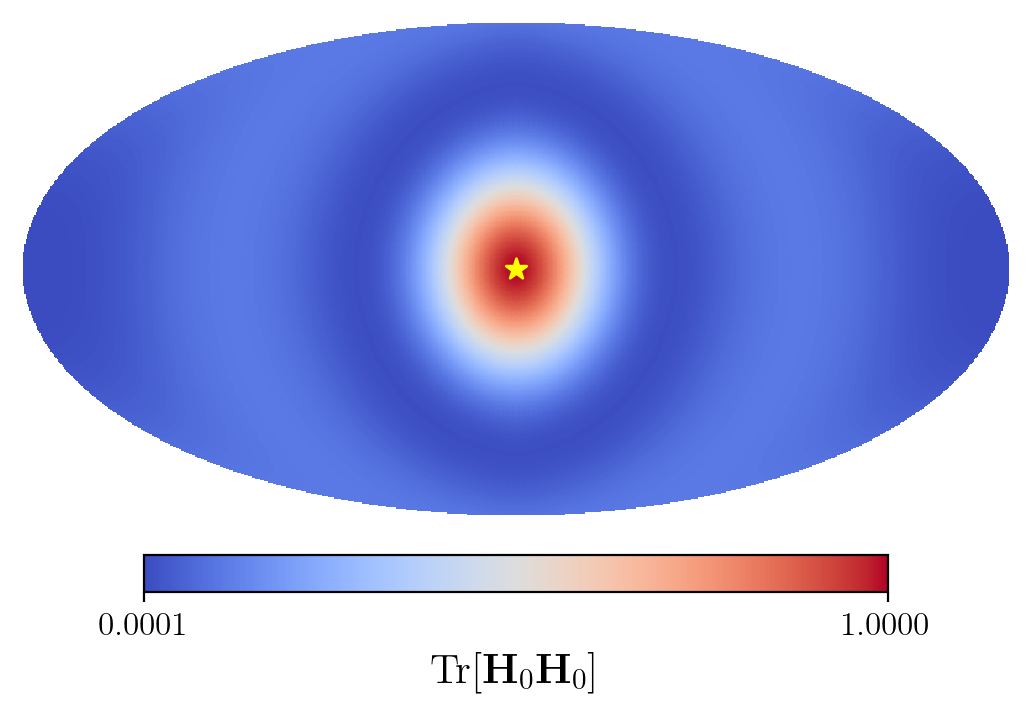

In [4]:
cmap = 'coolwarm' # Map color

fwhm = 0.2 # To upgrade the resolution of the map

sm = map_stars_H0H0
up_map = hp.ud_grade(map_stars_H0H0,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
#plt.axes(ax1)
hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta,phi,marker='*',color='yellow',s=60)
#hp.graticule()
f = plt.gcf()

# To change the visualisation of the bar in the plot
ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$\mathrm{Tr}[\mathbf{H}_0 \mathbf{H}_0]$',size=15)

plt.savefig('TraceH0H0_monopole.pdf',bbox_inches='tight')

# Dipole visualisation
We consider:
* $\bf{v} = (l,b)= (264^{\circ},48^{\circ})$. The file **response.py** contains this direction as **vvec**.
* $\bf{n} = (l,b)=(0^{\circ},0^{\circ})$ for the first case, and $\bf{n}=v$ for the second.
* $\bf q$ is the direction of stars in each of the pixels defined on the map. Is called **stars_vec** in the code.

In [5]:
nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)

stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T
print(stars_vec.shape)

# Getting the angles of vvec to for the map
thetaVvec, phiVvec = hp.vec2ang(vvec)


# ---- Different values for n, to see how the plots change when choosing a different direction.---

#n1 = get_vec(theta,phi) # Star at the center of the map
#n1 = jnp.array([0.96388439, -0.26566278, 0.01871302]) # Random position in the Sky (close to the centre)
#n1 = jnp.array([9.61440915e-04, -2.51119328e-01, -9.67955659e-01]) # Random position in the Sky (south pole)
n1 = -vvec # Opposite to V
#n1= jnp.array([-0.18639486, -0.72313051, -0.66508587]) # Orthogonal to V

theta_n1, phi_n1 = hp.vec2ang(n1)

#--------------------------------------------------------


# ------------------- Tr[H1H1] ---------------------
f = lambda q: trace_pair_pair_H1(n1,q,pvec_array,nside)
map_stars_H1H1= vmap(f)(stars_vec)
#print(map_stars_H1H1.shape)

## Another way to calculate Trace of H1*H1
f = lambda q: jnp.trace(jnp.square(pairwise_dipole(n1,q,pvec_array,nside)))
map_stars_sqH1H1 = vmap(f)(stars_vec)

#print(map_stars_sqH1H1.shape)


(768, 3)


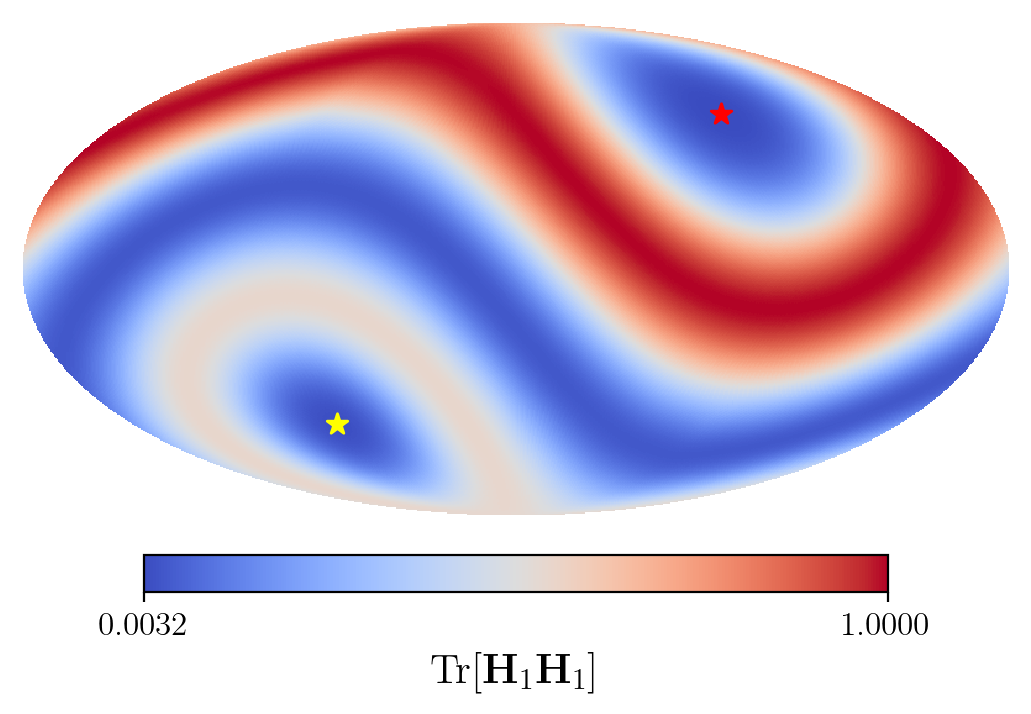

In [6]:
sm = map_stars_H1H1
up_map = hp.ud_grade(map_stars_H1H1,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)

hp.mollview(sm/max, cmap=cmap, cbar=False, title="", hold=True)
hp.projscatter(theta_n1, phi_n1, color='yellow', s=60, marker='*')
hp.projscatter(thetaVvec, phiVvec, color='red', s=60, marker='*')
#hp.graticule(color="gray")
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$\mathrm{Tr}[\mathbf{H}_1 \mathbf{H}_1]$',size=15)

plt.savefig('TraceH1H1_dipole.pdf',bbox_inches='tight')
#plt.savefig('TraceH1H1_dipole_centre.pdf',bbox_inches='tight')
#plt.savefig('TraceH1H1_dipole_Random.pdf',bbox_inches='tight')